In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [3]:
data = pd.read_csv('covid19model.csv')

In [4]:
toy_data = pd.read_csv('toy_data.csv')
toy_data

,Unnamed: 0,0
0,0,9.319691e-16
1,1,2.800236e-02
2,2,6.963707e-02
3,3,1.213362e-01
4,4,1.795116e-01
...,...,...
402,402,4.089112e-03
403,403,3.417061e-03
404,404,2.855353e-03
405,405,2.385894e-03


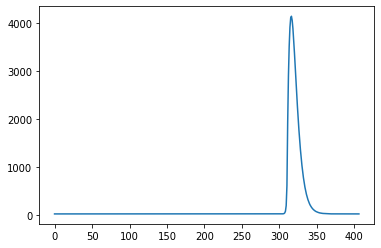

In [5]:
toy_data_np = toy_data['0'].round() + 20
plt.plot(toy_data_np)

    # Toy Data
    tau = torch.tensor(33) # bij_transform(tau_prime, lower=0, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = torch.tensor(3.6) # bij_transform(R0_prime, lower=2, upper=5)
    phi = torch.tensor(25) # bij_transform(phi_prime, lower=1, upper=50)
    alpha = torch.tensor(0.01) # bij_transform(alpha_prime, lower=0, upper=0.05)
    sigma = torch.tensor(0.1) #bij_transform(sigma_prime, lower=0.0001, upper=0.5)

# Initialization

In [6]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(toy_data_np, requires_grad=False, device=device, dtype=dtype)
#observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [7]:
"""tau_prime = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True,
                         device=device,
                         dtype=dtype)  # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0_prime = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True,
                        device=device,
                        dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha_prime = torch.tensor(
    truncnorm.rvs((0 - 1 / 100) / 1 / 100, (5 / 100 - 1 / 100) / 1 / 100, loc=1 / 100, scale=1 / 100),
    requires_grad=True, device=device,
    dtype=dtype)  # uniform distribution between (0-5%) # probability to get hospitalized
sigma_prime = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True,
                           device=device,
                           dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step"""

'tau_prime = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)\nphi_prime = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True,\n                         device=device,\n                         dtype=dtype)  # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations\nR0_prime = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True,\n                        device=device,\n                        dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number\nalpha_prime = torch.tensor(\n    truncnorm.rvs((0 - 1 / 100) / 1 / 100, (5 / 100 - 1 / 100) / 1 / 100, loc=1 / 100, scale=1 / 100),\n    requires_grad=True, device=device,\n    dtype=dtype)  # uniform distribution between (0-5%) # probability to get hospitalized\nsigma_prime = torch.tensor(truncnorm.r

In [10]:
tau_prime = torch.tensor(-200.0, requires_grad=True, device=device, dtype=dtype)
R0_prime = torch.tensor(-5.0, requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(-5.0, requires_grad=True, device=device, dtype=dtype)
alpha_prime = torch.tensor(0.05, requires_grad=True, device=device, dtype=dtype)
sigma_prime = torch.tensor(0.05, requires_grad=True, device=device, dtype=dtype)

In [11]:
epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma_prime.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma_prime.detach()).rsample()
epsilon_t.requires_grad_(True)


tensor([-0.0695, -0.1103, -0.1263, -0.0894, -0.1771, -0.1469, -0.1595, -0.1814,
        -0.2100, -0.3701, -0.3420, -0.3312, -0.4410, -0.4519, -0.4882, -0.3958,
        -0.3834, -0.3695, -0.2886, -0.3003, -0.3672, -0.3703, -0.3838, -0.3389,
        -0.2989, -0.3245, -0.3454, -0.3029, -0.2037, -0.2671, -0.2223, -0.1691,
        -0.2050, -0.1481, -0.2321, -0.2276, -0.2358, -0.2864, -0.2667, -0.2378,
        -0.1698, -0.1891, -0.2192, -0.2910, -0.2821, -0.3296, -0.3342, -0.2761,
        -0.3391, -0.2981, -0.2720, -0.2674, -0.2176, -0.2665, -0.1948, -0.1857,
        -0.1808, -0.1091, -0.0950, -0.0753, -0.0339, -0.0418, -0.0075,  0.0152,
        -0.0059,  0.0159,  0.0421, -0.0437, -0.1078, -0.2018, -0.2780, -0.2879,
        -0.2622, -0.3167, -0.3293, -0.3751, -0.4484, -0.4603, -0.4520, -0.4536,
        -0.4708, -0.5246, -0.5901, -0.5987, -0.6891, -0.7121, -0.7412, -0.7183,
        -0.7448, -0.7812, -0.7189, -0.6978, -0.6867, -0.6885, -0.6145, -0.5470,
        -0.6019, -0.5288, -0.4738, -0.35

## Init Distributions

In [12]:
dist_tau = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))

# Define Forward Pass

In [13]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime/upper))
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inv(transf, lower, upper):
    return -torch.log(((upper-lower)/(transf-lower)-1)**upper)

def bij_transform_inf(prime):
    return torch.exp(prime)

In [14]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += dist_tau.log_prob(tau)[0]

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_R0.log_prob(R0)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    ll += dist_sigma.log_prob(sigma)[0]

    return ll

In [15]:
def calc_prior_loss_abs(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += (tau - (1 / 0.03)) ** 2 * 1e-1

    ll += (phi - 25) ** 2 * 1e-1

    ll += (R0 - 3.6) ** 2 * 1e3

    ll += (alpha - 0.01) ** 2 * 1e6

    ll += (sigma - 0.1) ** 2 * 1e4

    #ll = (-1) * ll
    
    return ll

In [16]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St


In [17]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    #for t in range(1, num_observations):
    #    dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
    #    ll += dist_epsilon_t.log_prob(epsilon_t[t])

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations-1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())

    eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations - 1].clone()
    Rt = torch.exp(eta_t)
    #ll = (-1) * ll
    return Rt, ll


In [18]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected


In [19]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit


In [20]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i] / phi)
        if p == 1:
            p = p.clone() - torch.tensor(2.225e-5)
        if p < 2.225e-5:
            p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])
    ll = (-1) * ll
    return ll


In [21]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, lower=0.000001, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=0.000001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.000001, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0.000001, upper=0.5)


    # Calculate prior loss
    ll_prior = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll_rw = calc_Rt(R0, epsilon_t, sigma, torch.tensor(0.0, device=device)) ##ll

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)

    # Compare observed hospitalizations to model results
    ll_comp = compare_results(expected_daily_hospit, phi, torch.tensor(0.0, device=device)) ##ll

    return expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma


# Optimization


Prior Loss:-1793.5535888671875  Random Walk Loss:162.99313354492188 Comparison Loss:57172.50390625 


Time Step: 0 || Loss: 55541.9453125 || Learning Rate: 1e-06

R0:2.806824264109985  grad:1839.971517986253
alpha:0.03655319787292162  grad:-1663.1095284828418
phi:23.75104115103219  grad:587.6776770974358
sigma:0.2624900687602825  grad:-372.9416155886489
epsilon_t.mean:-0.06458870321512222  grad.mean:107.55641174316406
tau:53.788285005057595  grad:1.9589518529416137

This Run:  0.5196065902709961 seconds


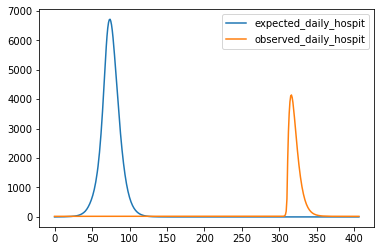

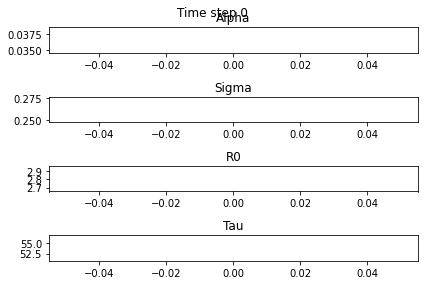


Prior Loss:-1790.4732666015625  Random Walk Loss:164.44400024414062 Comparison Loss:45790.06640625 


Time Step: 10 || Loss: 44164.0390625 || Learning Rate: 9.996333962710562e-07

R0:2.8170929108045346  grad:9866.583588665564
alpha:0.0004366805160377279  grad:-135844.06467946983
phi:23.752390535930903  grad:598.5558080477826
sigma:0.26155832817484553  grad:-374.41384960263906
epsilon_t.mean:-0.06964800506830215  grad.mean:574.3170776367188
tau:53.788348493635006  grad:20.07470117102615

This Run:  0.46537232398986816 seconds


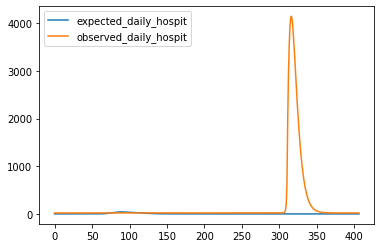


Prior Loss:-1790.51123046875  Random Walk Loss:165.85601806640625 Comparison Loss:79978.9765625 


Time Step: 20 || Loss: 78354.3203125 || Learning Rate: 9.98600947697464e-07

R0:2.819441356759337  grad:511.80725359326453
alpha:1.1350814304293664e-06  grad:-6231.286773458339
phi:23.754545498773723  grad:923.4021030480768
sigma:0.26062329799865774  grad:-375.797641646417
epsilon_t.mean:-0.07079613208770752  grad.mean:29.754823684692383
tau:53.788347479585006  grad:-4.763214924499211

This Run:  0.4344940185546875 seconds


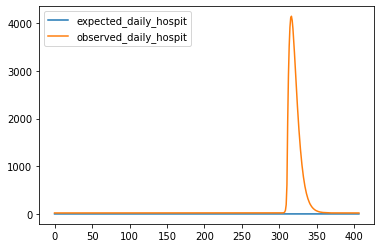


Prior Loss:-1790.5084228515625  Random Walk Loss:167.26980590820312 Comparison Loss:78605.3359375 


Time Step: 30 || Loss: 76982.09375 || Learning Rate: 9.969046953029745e-07

R0:2.820277920360369  grad:132.6195600661349
alpha:1.053100463363174e-06  grad:-2481.724166952397
phi:23.756825463502963  grad:907.2431243754515
sigma:0.2596857955926404  grad:-377.17012666129847
epsilon_t.mean:-0.07120425254106522  grad.mean:7.701199531555176
tau:53.78833837811799  grad:-7.364649134212583

This Run:  0.431110143661499 seconds


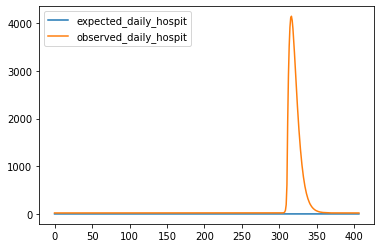


Prior Loss:-1790.505615234375  Random Walk Loss:168.68923950195312 Comparison Loss:78554.21875 


Time Step: 40 || Loss: 76932.40625 || Learning Rate: 9.94548003689325e-07

R0:2.8208189013667306  grad:1455.129160121699
alpha:1.0341724851541842e-06  grad:-2174.819120318984
phi:23.759106199509784  grad:915.3662387258644
sigma:0.2587464845380706  grad:-378.54031333266664
epsilon_t.mean:-0.07146792113780975  grad.mean:84.56478118896484
tau:53.788327539038974  grad:-0.7165017306258314

This Run:  0.4326355457305908 seconds


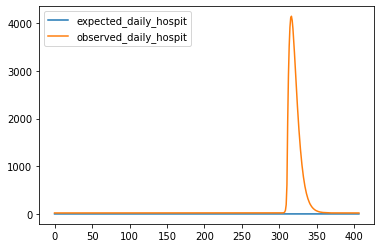


Prior Loss:-1790.5025634765625  Random Walk Loss:170.116455078125 Comparison Loss:77626.8828125 


Time Step: 50 || Loss: 76006.5 || Learning Rate: 9.915355499156789e-07

R0:2.8216613845422067  grad:968.0654886215773
alpha:1.0247301670049473e-06  grad:-1729.2232842842452
phi:23.76138636220238  grad:908.6217397027391
sigma:0.2578060266061541  grad:-379.91297976393065
epsilon_t.mean:-0.07187826931476593  grad.mean:56.23712921142578
tau:53.788319003078534  grad:-5.298909664116803

This Run:  0.42377424240112305 seconds


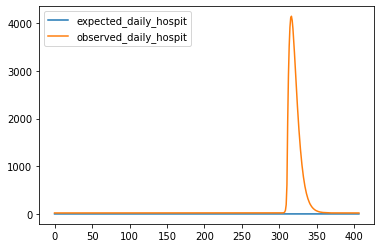

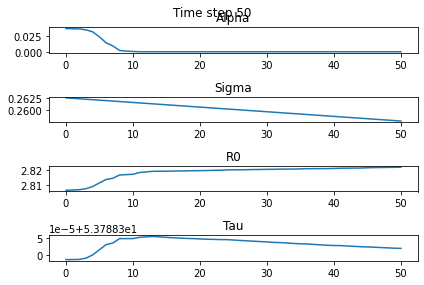


Prior Loss:-1790.4996337890625  Random Walk Loss:171.54949951171875 Comparison Loss:79983.7734375 


Time Step: 60 || Loss: 78364.8203125 || Learning Rate: 9.878733080315709e-07

R0:2.8225053767813177  grad:694.7772103135113
alpha:1.0193964886994634e-06  grad:-1031.9855152370421
phi:23.763658053738975  grad:924.1406198178965
sigma:0.2568650850697809  grad:-381.284427770687
epsilon_t.mean:-0.07228895276784897  grad.mean:40.345088958740234
tau:53.78831088456554  grad:-3.6085612070061845

This Run:  0.4313390254974365 seconds


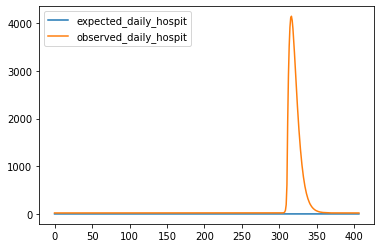


Prior Loss:-1790.4962158203125  Random Walk Loss:172.98870849609375 Comparison Loss:80138.5078125 


Time Step: 70 || Loss: 78521.0 || Learning Rate: 9.835685293349652e-07

R0:2.8237733316771663  grad:580.5083083137287
alpha:1.0157802522209585e-06  grad:-823.71849225821
phi:23.765919730617696  grad:925.0526241759345
sigma:0.25592432708650764  grad:-382.6569004717232
epsilon_t.mean:-0.07290522009134293  grad.mean:33.691070556640625
tau:53.78830669069342  grad:-4.30202864678535

This Run:  0.43161845207214355 seconds


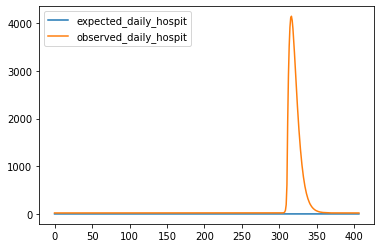


Prior Loss:-1790.4935302734375  Random Walk Loss:174.42868041992188 Comparison Loss:79901.5234375 


Time Step: 80 || Loss: 78285.4609375 || Learning Rate: 9.786297184467411e-07

R0:2.824389696390572  grad:751.4423853759365
alpha:1.0135518223726111e-06  grad:-737.3033520762914
phi:23.768181961525904  grad:923.6066071043459
sigma:0.25498442524023424  grad:-384.02092639364434
epsilon_t.mean:-0.07320442795753479  grad.mean:43.603336334228516
tau:53.78829698814027  grad:-3.2882098328649674

This Run:  0.4268612861633301 seconds


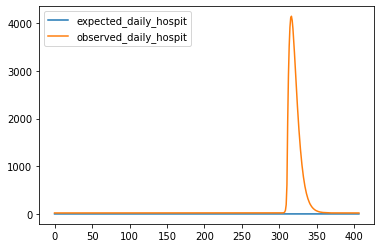


Prior Loss:-1790.490478515625  Random Walk Loss:175.87274169921875 Comparison Loss:80363.8828125 


Time Step: 90 || Loss: 78749.265625 || Learning Rate: 9.730666053121087e-07

R0:2.8253864937159983  grad:352.24749681380433
alpha:1.0117100271336369e-06  grad:-588.9268635344922
phi:23.770418574649266  grad:926.143889652281
sigma:0.25404605700122845  grad:-385.3835016529141
epsilon_t.mean:-0.07368790358304977  grad.mean:20.426998138427734
tau:53.78828956845121  grad:-5.771675316604294

This Run:  0.425417423248291 seconds


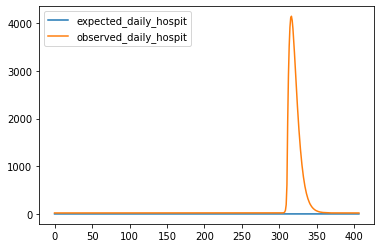


Prior Loss:-1790.4874267578125  Random Walk Loss:177.31832885742188 Comparison Loss:79898.46875 


Time Step: 100 || Loss: 78285.296875 || Learning Rate: 9.66890113257973e-07

R0:2.8263245119254137  grad:755.3847182757488
alpha:1.010350395008708e-06  grad:-567.2866167433644
phi:23.77264756426665  grad:923.5486828245621
sigma:0.2531098922415177  grad:-386.7405200555945
epsilon_t.mean:-0.07414237409830093  grad.mean:43.798423767089844
tau:53.788282357631545  grad:-3.2734298068178282

This Run:  0.4641268253326416 seconds


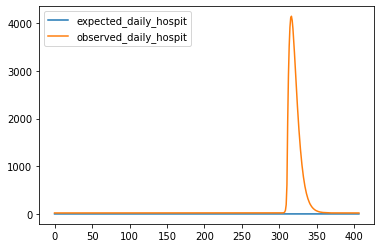

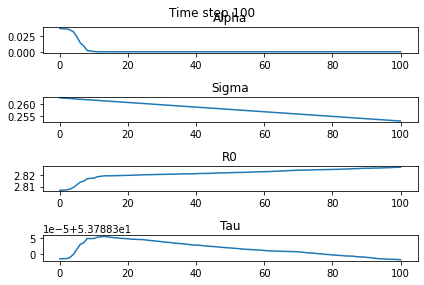


Prior Loss:-1790.484619140625  Random Walk Loss:178.76373291015625 Comparison Loss:80311.46875 


Time Step: 110 || Loss: 78699.75 || Learning Rate: 9.601123232530442e-07

R0:2.8271619424395693  grad:418.54514216544857
alpha:1.0092268758342654e-06  grad:-472.3973711352265
phi:23.77485255001635  grad:925.8634082613793
sigma:0.25217659842906337  grad:-388.0905280133447
epsilon_t.mean:-0.0745476633310318  grad.mean:24.256145477294922
tau:53.788273156872556  grad:-5.3452168400688524

This Run:  0.4428098201751709 seconds


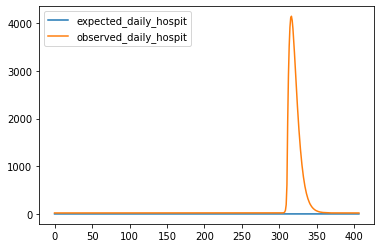


Prior Loss:-1790.4820556640625  Random Walk Loss:180.20761108398438 Comparison Loss:78098.859375 


Time Step: 120 || Loss: 76488.5859375 || Learning Rate: 9.527464345343579e-07

R0:2.82775961465873  grad:1677.5945712328219
alpha:1.0084255903728796e-06  grad:-597.5908732718252
phi:23.777057932430683  grad:912.9978706378805
sigma:0.25124684500766215  grad:-389.43167517377753
epsilon_t.mean:-0.07483667880296707  grad.mean:97.2247314453125
tau:53.78826349512942  grad:-1.1277719649618765

This Run:  0.431182861328125 seconds


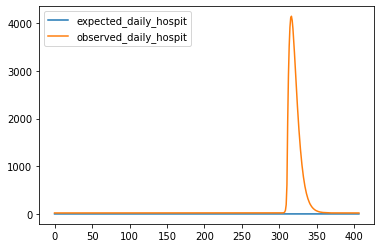


Prior Loss:-1790.478759765625  Random Walk Loss:181.652099609375 Comparison Loss:80396.3671875 


Time Step: 130 || Loss: 78787.5390625 || Learning Rate: 9.448067217798272e-07

R0:2.8289130246363596  grad:222.76111610893545
alpha:1.0076420645881469e-06  grad:-380.55093403699664
phi:23.779226583881357  grad:925.8237367023416
sigma:0.25032128687835586  grad:-390.76873434235097
epsilon_t.mean:-0.07539393752813339  grad.mean:12.896971702575684
tau:53.78825687467959  grad:-6.6959392524058705

This Run:  0.4385817050933838 seconds


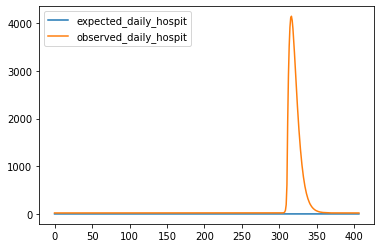


Prior Loss:-1790.4757080078125  Random Walk Loss:183.09405517578125 Comparison Loss:79608.75 


Time Step: 140 || Loss: 78001.3671875 || Learning Rate: 9.363084890213014e-07

R0:2.830083823854636  grad:963.1737140470435
alpha:1.0069883806751929e-06  grad:-404.03930582689367
phi:23.78137735420519  grad:921.7151694640401
sigma:0.24940057500402413  grad:-392.09698748142137
epsilon_t.mean:-0.07595885545015335  grad.mean:55.76616287231445
tau:53.788249578990985  grad:-2.1478074226026584

This Run:  0.4243760108947754 seconds


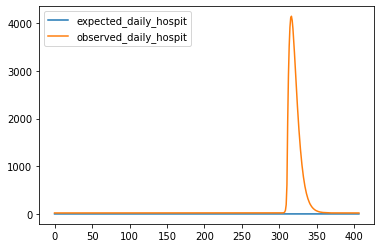


Prior Loss:-1790.4725341796875  Random Walk Loss:184.53118896484375 Comparison Loss:80252.1953125 


Time Step: 150 || Loss: 78646.25 || Learning Rate: 9.272680205063656e-07

R0:2.8309935756849205  grad:474.03514058878756
alpha:1.0064836044215995e-06  grad:-338.7733489791903
phi:23.783515232085055  grad:925.4362991001148
sigma:0.24848534919563664  grad:-393.4133957518384
epsilon_t.mean:-0.07639726251363754  grad.mean:27.431875228881836
tau:53.78824244443475  grad:-5.0077882865917855

This Run:  0.4401214122772217 seconds


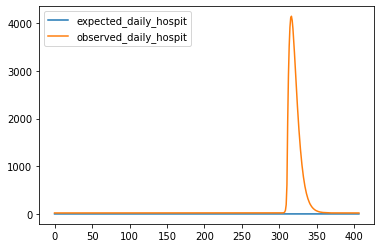

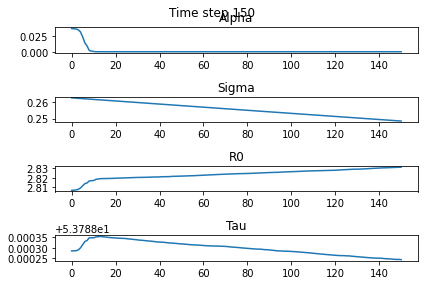


Prior Loss:-1790.469482421875  Random Walk Loss:185.96417236328125 Comparison Loss:80228.1328125 


Time Step: 160 || Loss: 78623.625 || Learning Rate: 9.177025287296351e-07

R0:2.8320894239037493  grad:496.2377021966351
alpha:1.006027340522175e-06  grad:-317.0043775263348
phi:23.785628054678664  grad:925.2853212821148
sigma:0.24757624454249105  grad:-394.7201384271153
epsilon_t.mean:-0.07692479342222214  grad.mean:28.70489501953125
tau:53.78823524818577  grad:-4.87023381399442

This Run:  0.4315965175628662 seconds


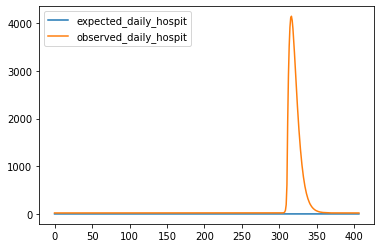


Prior Loss:-1790.466552734375  Random Walk Loss:187.39166259765625 Comparison Loss:80376.703125 


Time Step: 170 || Loss: 78773.625 || Learning Rate: 9.076300998655644e-07

R0:2.833241283076511  grad:254.11557558535236
alpha:1.0056504266891476e-06  grad:-285.3673846134146
phi:23.787723723493432  grad:925.6579032577527
sigma:0.2466738790701412  grad:-396.01561073695524
epsilon_t.mean:-0.07747858017683029  grad.mean:14.688714981079102
tau:53.78823073802156  grad:-6.496740257566001

This Run:  0.437044620513916 seconds


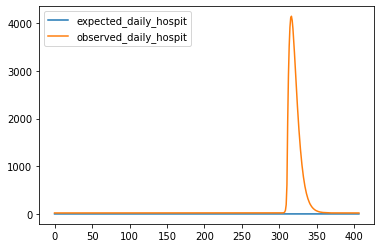


Prior Loss:-1790.463623046875  Random Walk Loss:188.8111572265625 Comparison Loss:78699.9296875 


Time Step: 180 || Loss: 77098.2734375 || Learning Rate: 8.970696368447124e-07

R0:2.834191537411769  grad:1912.5470156550023
alpha:1.0053361674862038e-06  grad:-358.73936117489944
phi:23.789800146003454  grad:916.8214093495943
sigma:0.24577886385219433  grad:-397.2963766682745
epsilon_t.mean:-0.0779348835349083  grad.mean:110.56548309326172
tau:53.78822459587814  grad:1.6146561556334464

This Run:  0.43609189987182617 seconds


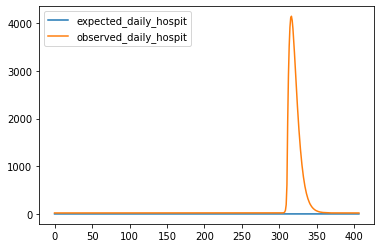


Prior Loss:-1790.460693359375  Random Walk Loss:190.2235107421875 Comparison Loss:80171.0546875 


Time Step: 190 || Loss: 78570.8203125 || Learning Rate: 8.8604080032396e-07

R0:2.835312315719267  grad:530.8486444130929
alpha:1.005036667638522e-06  grad:-268.811346984308
phi:23.7918436902801  grad:924.86333012563
sigma:0.24489178820605442  grad:-398.5652230985893
epsilon_t.mean:-0.07847245782613754  grad.mean:30.669485092163086
tau:53.78821918055057  grad:-4.674131069772435

This Run:  0.44332146644592285 seconds


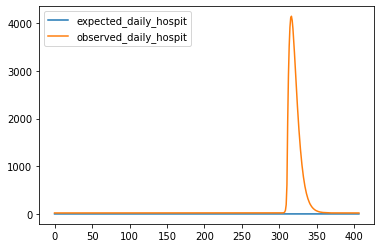


Prior Loss:-1790.457763671875  Random Walk Loss:191.6270751953125 Comparison Loss:80117.203125 


Time Step: 200 || Loss: 78518.375 || Learning Rate: 8.745639478083059e-07

R0:2.8364707350367957  grad:571.2385574014146
alpha:1.0047827840523357e-06  grad:-258.07276105388456
phi:23.793867604677946  grad:924.5334401503192
sigma:0.24401322750665894  grad:-399.81996080029177
epsilon_t.mean:-0.07902740687131882  grad.mean:32.98904037475586
tau:53.78821531786827  grad:-4.429959765458727

This Run:  0.43249988555908203 seconds


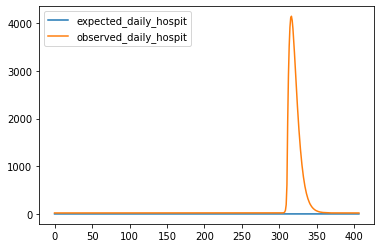

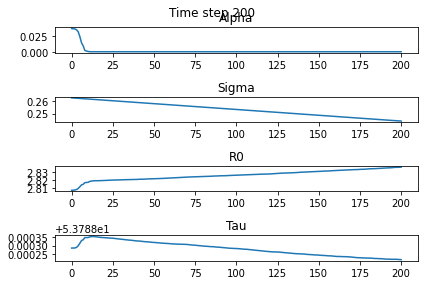


Prior Loss:-1790.4547119140625  Random Walk Loss:193.02145385742188 Comparison Loss:77158.2109375 


Time Step: 210 || Loss: 75560.78125 || Learning Rate: 8.626600711875596e-07

R0:2.8377874938970953  grad:1843.1981601434538
alpha:1.0045345366265164e-06  grad:-367.90632044046873
phi:23.795855875359912  grad:907.7562410489688
sigma:0.24314374088602286  grad:-401.06108182897333
epsilon_t.mean:-0.07965732365846634  grad.mean:106.4100341796875
tau:53.78821093077043  grad:-3.4997959244187147

This Run:  0.445906400680542 seconds


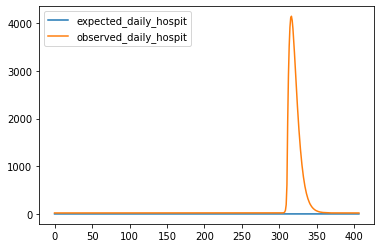


Prior Loss:-1790.451904296875  Random Walk Loss:194.40359497070312 Comparison Loss:77067.1796875 


Time Step: 220 || Loss: 75471.1328125 || Learning Rate: 8.503507329554807e-07

R0:2.8387714034025633  grad:939.0201667772093
alpha:1.0043273006640533e-06  grad:-339.22579318873545
phi:23.797821284084694  grad:905.2858021440204
sigma:0.2422838674849296  grad:-402.28410273010667
epsilon_t.mean:-0.08012738823890686  grad.mean:54.18653869628906
tau:53.788205166233546  grad:-7.609325625050345

This Run:  0.4328300952911377 seconds


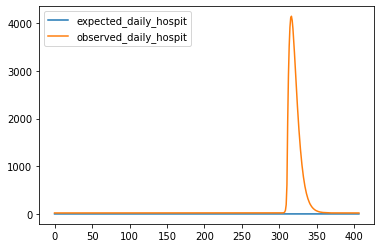


Prior Loss:-1790.4490966796875  Random Walk Loss:195.77420043945312 Comparison Loss:78435.0234375 


Time Step: 230 || Loss: 76840.3515625 || Learning Rate: 8.376580013816771e-07

R0:2.839783218413505  grad:2481.238133268269
alpha:1.004120944629387e-06  grad:-293.32921246265875
phi:23.79974601928726  grad:915.7567074581627
sigma:0.24143413241732478  grad:-403.49142693500164
epsilon_t.mean:-0.08061026781797409  grad.mean:143.1399383544922
tau:53.78819675492873  grad:3.8724085811401885

This Run:  0.4397919178009033 seconds


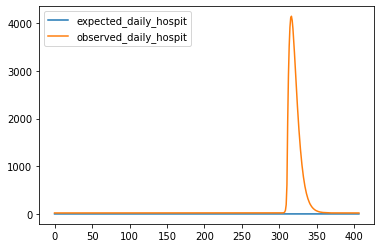


Prior Loss:-1790.446044921875  Random Walk Loss:197.13351440429688 Comparison Loss:79281.34375 


Time Step: 240 || Loss: 77688.03125 || Learning Rate: 8.246043849078623e-07

R0:2.8413276445451396  grad:1424.6160334266237
alpha:1.003943218911414e-06  grad:-245.67014751590685
phi:23.801650767758904  grad:919.8860520770935
sigma:0.2405950304580201  grad:-404.68441050871724
epsilon_t.mean:-0.08134632557630539  grad.mean:82.13349151611328
tau:53.788195129019655  grad:0.060810370967353915

This Run:  0.43511366844177246 seconds


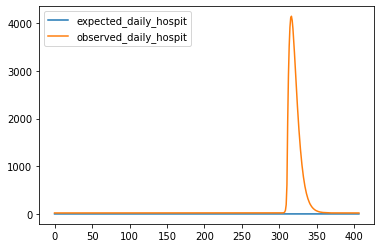


Prior Loss:-1790.443115234375  Random Walk Loss:198.47702026367188 Comparison Loss:79347.6875 


Time Step: 250 || Loss: 77755.71875 || Learning Rate: 8.112127660399225e-07

R0:2.8422896649004117  grad:1338.7540856376222
alpha:1.0037905383643267e-06  grad:-233.94479262283187
phi:23.803526806931572  grad:920.2071086388486
sigma:0.23976704045061215  grad:-405.85599054928696
epsilon_t.mean:-0.08180417120456696  grad.mean:77.15513610839844
tau:53.78818961773216  grad:-0.3309588655830773

This Run:  0.43555116653442383 seconds


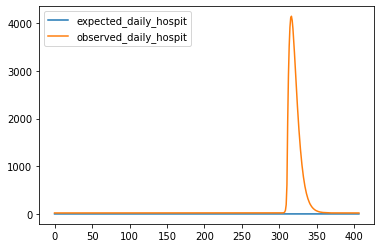

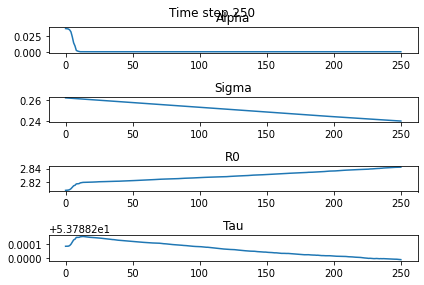


Prior Loss:-1790.4400634765625  Random Walk Loss:199.80767822265625 Comparison Loss:77890.2421875 


Time Step: 260 || Loss: 76299.609375 || Learning Rate: 7.975063350056383e-07

R0:2.843733019762169  grad:3131.2851120817186
alpha:1.003634550989971e-06  grad:-280.59436153379534
phi:23.80536202661972  grad:913.0128758521118
sigma:0.23895062236264006  grad:-407.01247169284414
epsilon_t.mean:-0.0824902132153511  grad.mean:180.37686157226562
tau:53.78818590664555  grad:5.904243851222836

This Run:  0.42986226081848145 seconds


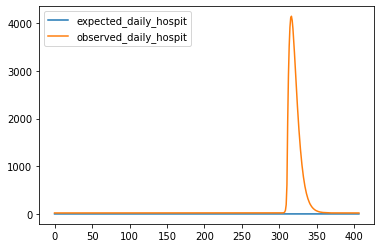


Prior Loss:-1790.4368896484375  Random Walk Loss:201.1236572265625 Comparison Loss:79163.0390625 


Time Step: 270 || Loss: 77573.7265625 || Learning Rate: 7.835085234449152e-07

R0:2.8454268656869495  grad:1770.3710132389092
alpha:1.0034868551648098e-06  grad:-224.0337401125622
phi:23.807162152009095  grad:919.4747128002948
sigma:0.2381462014747135  grad:-408.1517942339609
epsilon_t.mean:-0.08329395949840546  grad.mean:101.91453552246094
tau:53.78818340480091  grad:1.70040294949509

This Run:  0.4277029037475586 seconds


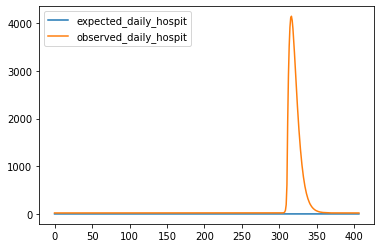


Prior Loss:-1790.43359375  Random Walk Loss:202.42315673828125 Comparison Loss:80068.1953125 


Time Step: 280 || Loss: 78480.1875 || Learning Rate: 7.692429383950052e-07

R0:2.8471240913288978  grad:573.419424966458
alpha:1.0033603130007292e-06  grad:-184.80462779160933
phi:23.808936952887954  grad:924.0290476546678
sigma:0.23735418306641146  grad:-409.2714295687921
epsilon_t.mean:-0.08409783244132996  grad.mean:32.98384094238281
tau:53.78818303716474  grad:-4.457974080236611

This Run:  0.435011625289917 seconds


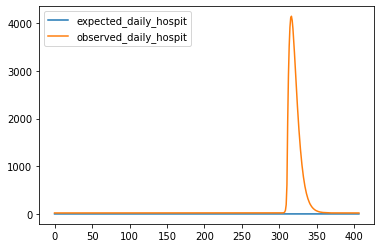


Prior Loss:-1790.430419921875  Random Walk Loss:203.70547485351562 Comparison Loss:75831.0078125 


Time Step: 290 || Loss: 74244.28125 || Learning Rate: 7.547332968275279e-07

R0:2.8487529195070884  grad:1575.5137002451424
alpha:1.0032427612185216e-06  grad:-301.20110093883034
phi:23.810675572571387  grad:899.4912491737355
sigma:0.23657495439206663  grad:-410.37099692407094
epsilon_t.mean:-0.08486790955066681  grad.mean:90.58635711669922
tau:53.788182533670536  grad:-8.72562160460694

This Run:  0.43002915382385254 seconds


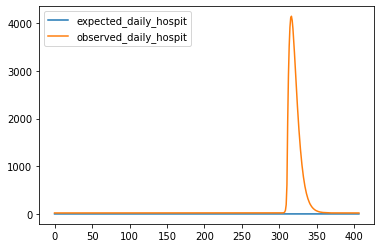

Complete Run:  142.70899558067322 seconds


In [22]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []
phi_vis = []
epsilon_mean_vis = []
loss_vis = []
prior_loss_vis = []
rw_loss_vis = []
comp_loss_vis = []
learning_rate_vis = []

learning_rate = 1e-6
epochs = 300
complete_time = time.time()


for k in range(epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs * 1000))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = ll_prior + ll_rw + ll_comp
    loss.backward()

    if k % 10 == 0:
        print(
            f'\nPrior Loss:{ll_prior}  Random Walk Loss:{ll_rw} Comparison Loss:{ll_comp} \n'
            f'\n\nTime Step: {k} || Loss: {loss} || Learning Rate: {learning_rate}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    

    
    with torch.no_grad():  # this part is SGD. can also replace with loss.step
        tau_prime -= learning_rate * tau_prime.grad
        phi_prime -= learning_rate * phi_prime.grad
        R0_prime -= learning_rate * R0_prime.grad
        alpha_prime -= learning_rate * alpha_prime.grad
        sigma_prime -= learning_rate * sigma_prime.grad
        epsilon_t -= learning_rate * epsilon_t.grad

        tau_prime.grad = None
        phi_prime.grad = None
        R0_prime.grad = None
        alpha_prime.grad = None
        sigma_prime.grad = None
        epsilon_t.grad = None


    # Visualization
    alpha_vis.append(alpha)
    sigma_vis.append(sigma)
    R0_vis.append(R0)
    tau_vis.append(tau)
    phi_vis.append(phi)
    epsilon_mean_vis.append(epsilon_t.abs().mean())
    loss_vis.append(loss)
    prior_loss_vis.append(ll_prior)
    rw_loss_vis.append(ll_rw)
    comp_loss_vis.append(ll_comp)
    learning_rate_vis.append(learning_rate)

    if k % 10 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()

    if k % 50 == 0:
        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))

# Evaluate Model

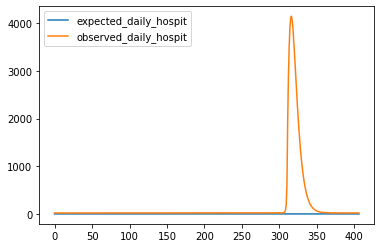

In [23]:
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

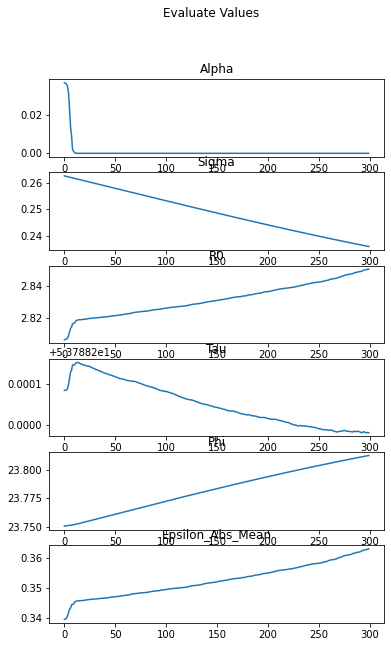

In [24]:
fig, axs = plt.subplots(6)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(alpha_vis)
axs[0].title.set_text('Alpha')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(R0_vis)
axs[2].title.set_text('R0')
axs[3].plot(tau_vis)
axs[3].title.set_text('Tau')
axs[4].plot(phi_vis)
axs[4].title.set_text('Phi')
axs[5].plot(epsilon_mean_vis)
axs[5].title.set_text('Epsilon_Abs_Mean')
plt.show()

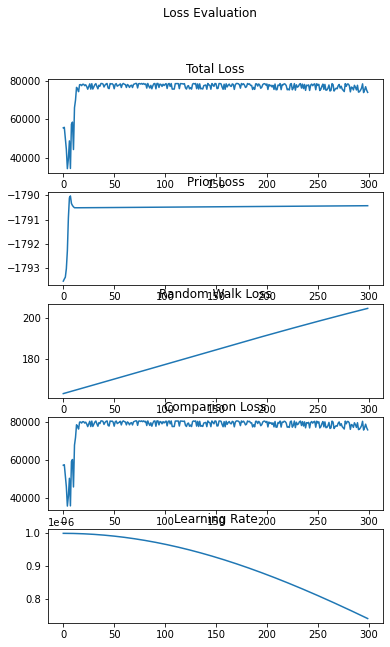

In [25]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[1].plot(prior_loss_vis)
axs[1].title.set_text('Prior Loss')
axs[2].plot(rw_loss_vis)
axs[2].title.set_text('Random Walk Loss')
axs[3].plot(comp_loss_vis)
axs[3].title.set_text('Comparison Loss')
axs[4].plot(learning_rate_vis)
axs[4].title.set_text('Learning Rate')
plt.show()